In [ ]:
import torch
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from rich import inspect
from torch.utils.data import random_split
from torchvision .models import resnet18, resnet34, resnet50, resnet101, resnet152
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
# load the mnist dataset using torchvision
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# count the labels of the whole dataset
labels = trainset.targets
labels_count = Counter(labels.numpy())
print(labels_count)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


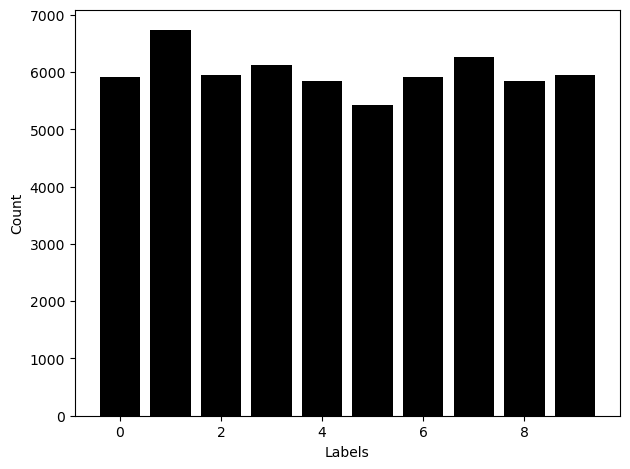

In [ ]:
# sort the dictionary by key
labels_count = dict(sorted(labels_count.items()))
plt.bar(labels_count.keys(), labels_count.values(), color = 'black')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The dataset is well balanced

In [ ]:
trainset.data.shape, trainset.targets.shape, testset.data.shape, testset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

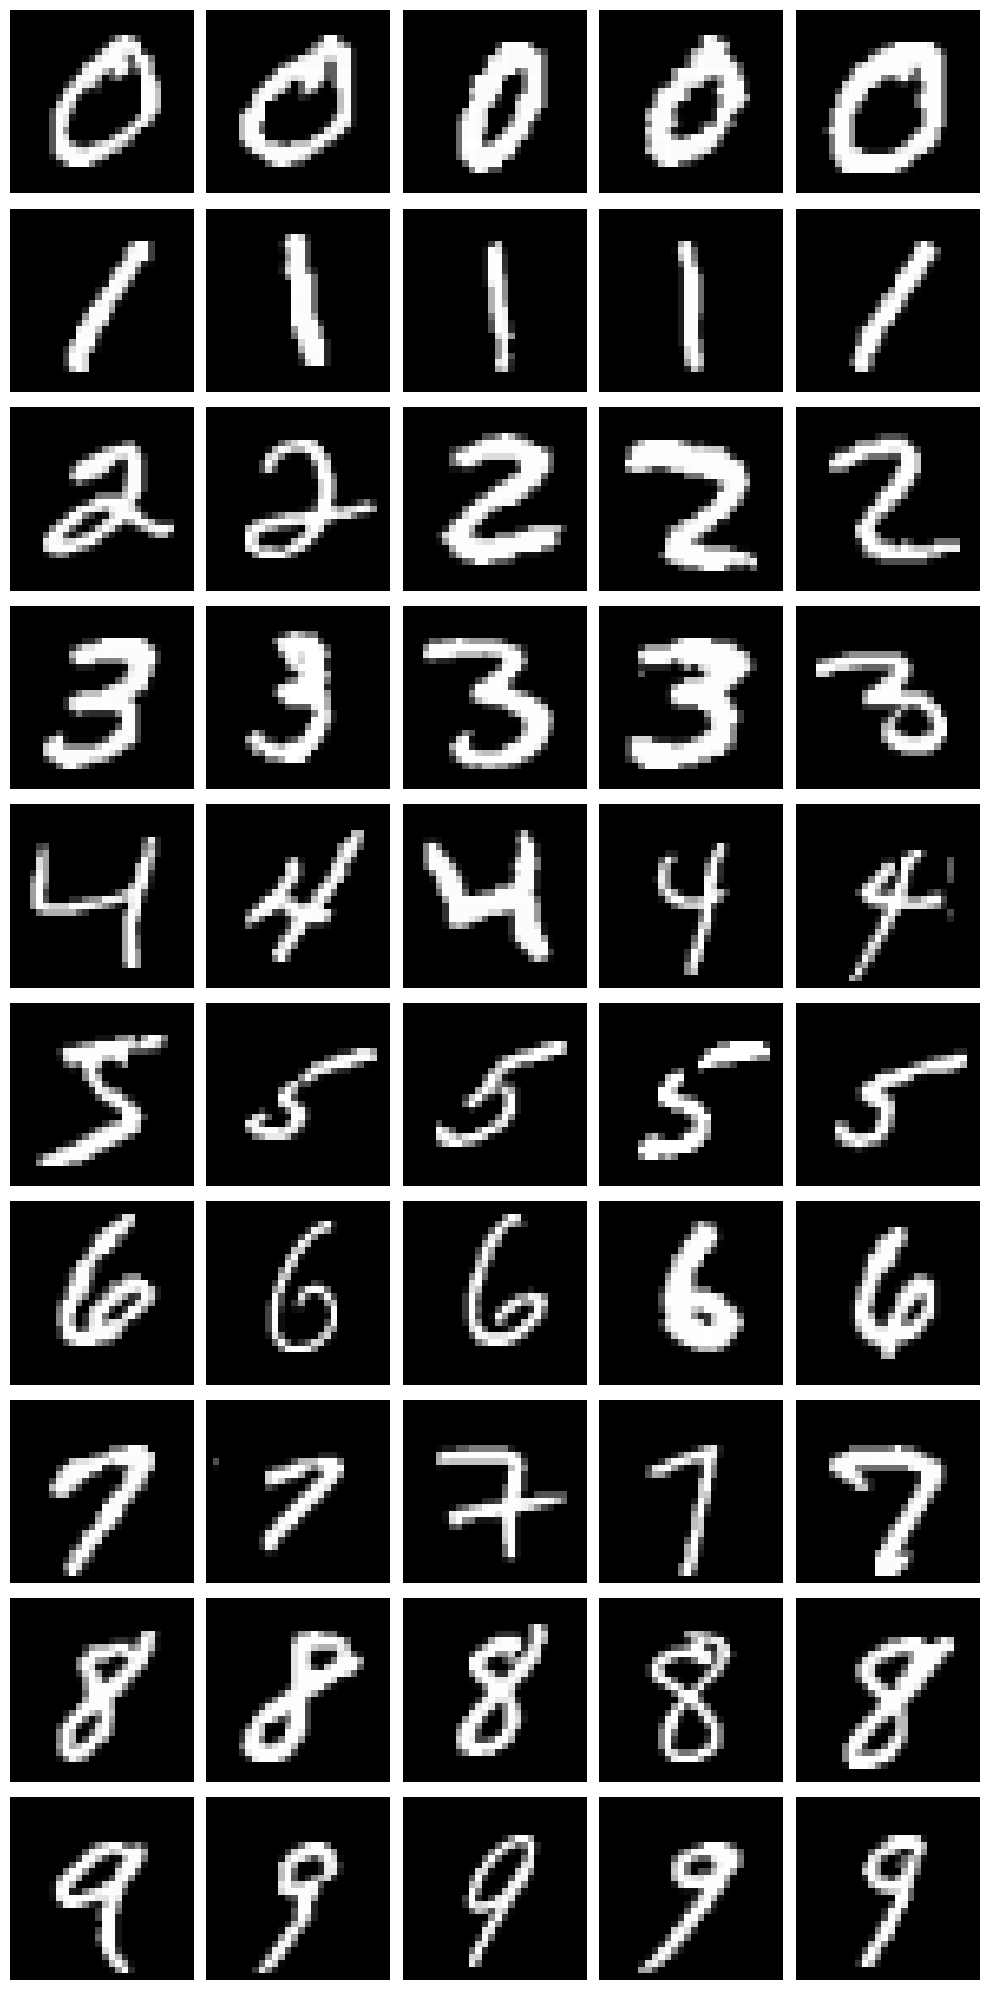

In [ ]:
# visualize 5 images from each class;
fig, axs = plt.subplots(10, 5, figsize=(10, 20))
for i in range(10):
    for j in range(5):
        axs[i, j].imshow(trainset.data[trainset.targets == i][j], cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
val_size = 0.2

num_validation = int(val_size * len(trainset))
num_train = len(trainset) - num_validation

traindataset, valset = random_split(trainset, [num_train, num_validation])

# val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
# trainloader = torch.utils.data.DataLoader(traindataset, batch_size=64, shuffle=True, num_workers=2)

In [105]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, use_dropout=True, dropout = 0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 25, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(25, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.use_dropout = use_dropout  # Check if dropout is enabled
        if self.use_dropout:
            self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10
use_dropout = True
dropout_rate = 0.2

# Split the dataset into train and validation sets
val_size = 0.2
num_validation = int(val_size * len(trainset))
num_train = len(trainset) - num_validation
traindataset, valset = random_split(trainset, [num_train, num_validation])

# Data Loaders
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)


# Initialize the model
NO_OF_CLASSES = 10
model = CNNModel(NO_OF_CLASSES,use_dropout= use_dropout,dropout= dropout_rate)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

wandb.init(project='mnist-cnn', config={
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'use_dropout': use_dropout,
    'dropout_rate': dropout_rate
})


train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Train the model
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(trainloader)
    train_acc /= len(traindataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        for images, labels in valloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()
        val_loss /= len(valloader)
        val_acc /= len(valset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Log the training and validation loss and accuracy to W&B
    wandb.log({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

    # Print the training and validation loss and accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred, class_names=[str(i) for i in range(10)])})
# wandb.log({'class_specific_metrics': wandb.plot.classification_report(probs=None, y_true=y_true, preds=y_pred, class_names=[str(i) for i in range(10)])})
wandb.log({'f1_score': f1_score(y_true, y_pred, average='macro')})
wandb.log({'accuracy': accuracy_score(y_true, y_pred)})
wandb.log({'recall': recall_score(y_true, y_pred, average='macro')})
wandb.log({'precision': precision_score(y_true, y_pred, average='macro')})
wandb.finish()

#### Already ran the above cell but accidentally cleared the output. Will take a lot of time to run again.

### 4.5

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm.notebook as tqdm


In [ ]:
PATH_TO_NOISY_DATA = "./SMAI_A3_dataset/mnist-with-awgn.mat"
mat = sio.loadmat(PATH_TO_NOISY_DATA)

In [ ]:
mat["test_x"].shape, mat["test_y"].shape, mat["train_x"].shape, mat["train_y"].shape

((10000, 784), (10000, 10), (60000, 784), (60000, 10))

In [ ]:
mat["train_x"] = mat["train_x"].reshape(60000, 1, 28, 28)
# mat["train_y"] = mat["train_y"].reshape(60000)
mat["test_x"] = mat["test_x"].reshape(10000, 1, 28, 28)
# mat["test_y"] = mat["test_y"].reshape(10000)

In [ ]:
X_train = torch.from_numpy(mat["train_x"]).float()
y_train = torch.from_numpy(mat["train_y"]).argmax(dim=1)
X_test = torch.from_numpy(mat["test_x"]).float()
y_test = torch.from_numpy(mat["test_y"]).argmax(dim=1)

0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 


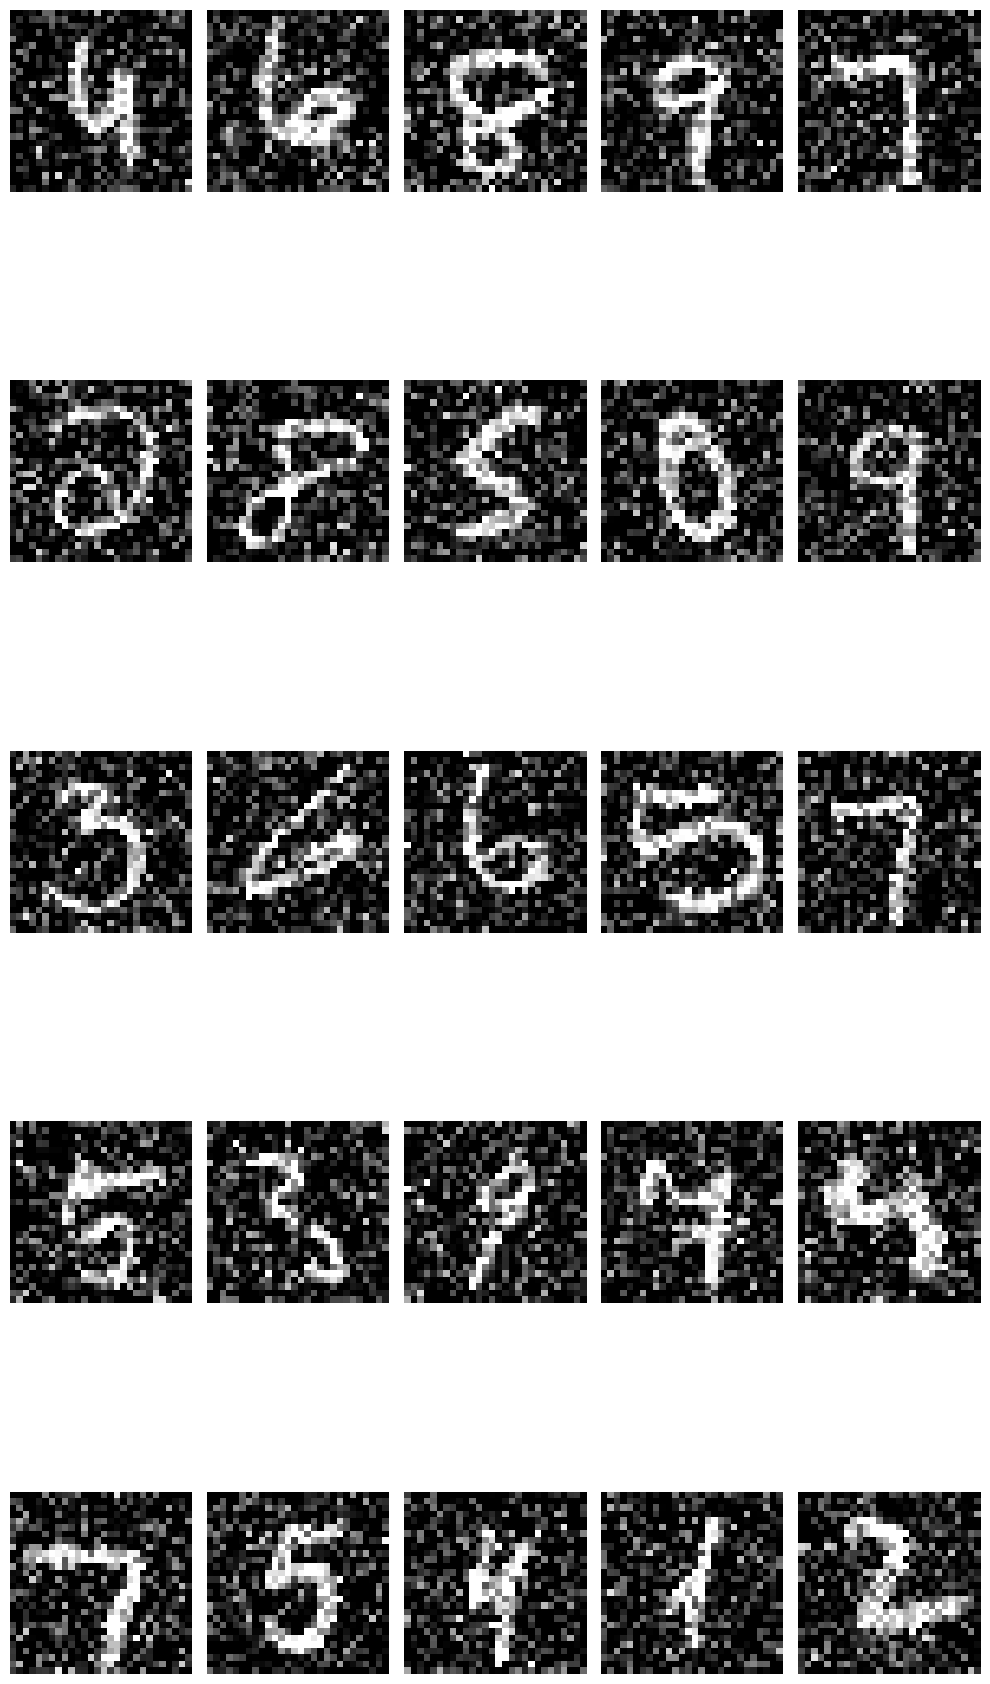

In [ ]:
# plot a couple of images in X_train
fig, axs = plt.subplots(5, 5, figsize=(10, 20))
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(X_train[i * 5 + j].squeeze(), cmap='gray')
        axs[i, j].axis('off')
        print(torch.argmax(y_train[i * 5 + j]).item(), end=" ")
    print(end="\n")
plt.tight_layout()
plt.show()


In [ ]:
epochs = 20
learning_rate = 0.001
use_dropout = True
dropout_rate = 0.2
batch_size = 32

In [ ]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset = torch.utils.data.TensorDataset(X_test, y_test)

# split validation set from train set
val_size = 0.15
num_validation = int(val_size * len(trainset))
num_train = len(trainset) - num_validation

trainset, valset = random_split(trainset, [num_train, num_validation], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize the model
NO_OF_CLASSES = 10
model = CNNModel(NO_OF_CLASSES,use_dropout= use_dropout,dropout= dropout_rate)


optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Train the model
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(trainloader)
    train_acc /= len(trainset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        for images, labels in valloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()
        val_loss /= len(valloader)
        val_acc /= len(valset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10, Train Loss: 0.5347, Train Acc: 0.8686, Val Loss: 0.2305, Val Acc: 0.9241
Epoch 2/10, Train Loss: 0.2726, Train Acc: 0.9158, Val Loss: 0.1867, Val Acc: 0.9407
Epoch 3/10, Train Loss: 0.2454, Train Acc: 0.9237, Val Loss: 0.1744, Val Acc: 0.9426
Epoch 4/10, Train Loss: 0.2129, Train Acc: 0.9336, Val Loss: 0.1811, Val Acc: 0.9454
Epoch 5/10, Train Loss: 0.1900, Train Acc: 0.9418, Val Loss: 0.1582, Val Acc: 0.9537
Epoch 6/10, Train Loss: 0.1769, Train Acc: 0.9442, Val Loss: 0.1383, Val Acc: 0.9589
Epoch 7/10, Train Loss: 0.1731, Train Acc: 0.9467, Val Loss: 0.1441, Val Acc: 0.9571
Epoch 8/10, Train Loss: 0.1589, Train Acc: 0.9496, Val Loss: 0.1286, Val Acc: 0.9622
Epoch 9/10, Train Loss: 0.1509, Train Acc: 0.9521, Val Loss: 0.1274, Val Acc: 0.9623
Epoch 10/10, Train Loss: 0.1455, Train Acc: 0.9547, Val Loss: 0.1306, Val Acc: 0.9600
Epoch 11/10, Train Loss: 0.1409, Train Acc: 0.9554, Val Loss: 0.1320, Val Acc: 0.9609
Epoch 12/10, Train Loss: 0.1364, Train Acc: 0.9574, Val Loss: 0

In [ ]:
model.eval()
with torch.inference_mode(True):
    y_true = []
    y_pred = []
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'F1 Score: {f1_score(y_true, y_pred, average="macro")}')
    print(f'Precision: {precision_score(y_true, y_pred, average="macro")}')
    print(f'Recall: {recall_score(y_true, y_pred, average="macro")}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}')
    print(f'Class Specific Metrics: \n{classification_report(y_true, y_pred)}')

Accuracy: 0.9637
F1 Score: 0.9635023195496087
Precision: 0.9635282560914641
Recall: 0.9635656503370053
Confusion Matrix: 
[[ 968    0    1    0    0    3    4    1    3    0]
 [   0 1125    4    0    0    1    1    1    3    0]
 [   6    4  985    4    5    0    3    6   18    1]
 [   2    0    5  971    0   19    0    2    6    5]
 [   0    3    3    0  945    0    4    0    1   26]
 [   1    0    1    9    1  867    4    3    4    2]
 [   3    4    0    0    7    8  931    1    4    0]
 [   1   14   16    4    6    0    0  980    3    4]
 [   2    1    3    8    5    6    5    4  929   11]
 [   3    7    2    4   25    3    1   19    9  936]]
Class Specific Metrics: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.95      0.96      0.96       9

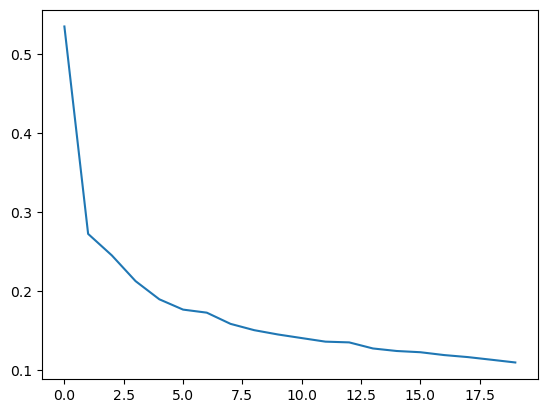

In [ ]:
plt.plot(train_losses, label='Training loss')

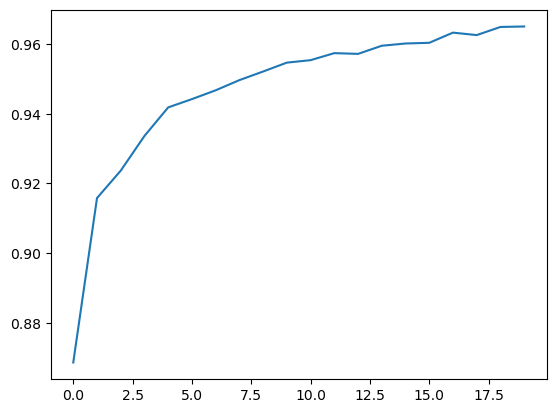

In [ ]:
plt.plot(train_accs, label='Training Accuracy')

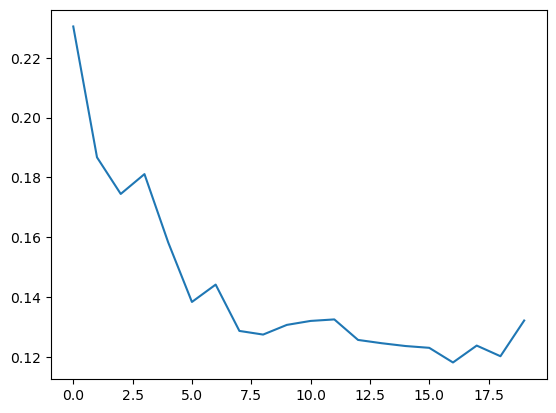

In [ ]:
plt.plot(val_losses, label='Validation loss')

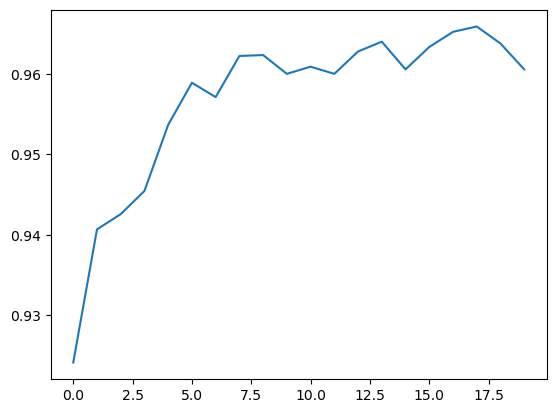

In [ ]:
plt.plot(val_accs, label='Validation accuracy')

### 4.6 AutoEncoder
#### Did this in colab kernel was crashing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [122]:
import torch
# import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from rich import inspect
from torch.utils.data import random_split
from torchvision .models import resnet18, resnet34, resnet50, resnet101, resnet152
import itertools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm.notebook import tqdm
import scipy.io as sio

In [97]:
PATH_TO_NOISY_DATA = "/content/drive/MyDrive/SMAI/mnist-with-awgn.mat"
mat = sio.loadmat(PATH_TO_NOISY_DATA)

mat["train_x"] = mat["train_x"].reshape(60000, 1, 28, 28)
# mat["train_y"] = mat["train_y"].reshape(60000)
mat["test_x"] = mat["test_x"].reshape(10000, 1, 28, 28)
# mat["test_y"] = mat["test_y"].reshape(10000)

X_train = torch.from_numpy(mat["train_x"]).float().cuda()
X_train = X_train / 255.0 # Normalize the values
y_train = torch.from_numpy(mat["train_y"]).argmax(dim=1).cuda()
X_test = torch.from_numpy(mat["test_x"]).float().cuda()
X_test = X_test / 255.0 # Normalize the values
y_test = torch.from_numpy(mat["test_y"]).argmax(dim=1).cuda()

epochs = 20
learning_rate = 0.001
use_dropout = True
dropout_rate = 0.2
batch_size = 32

trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset = torch.utils.data.TensorDataset(X_test, y_test)

# split validation set from train set
val_size = 0.15
num_validation = int(val_size * len(trainset))
num_train = len(trainset) - num_validation

trainset, valset = random_split(trainset, [num_train, num_validation], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [98]:
torch.min(X_train), torch.max(X_train)

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [111]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # N * 1 * 28 * 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # N, 16, 28, 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # N, 16, 14, 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # N, 32, 14, 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # N, 32, 7, 7
            nn.Conv2d(32, 64, 7),  # N, 64, 1, 1
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # N 32 7 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N 16 14 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N 1 28 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [112]:
autoencoder = AutoEncoder().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in tqdm(range(epochs)):
    for data in trainloader:
        images, _ = data
        optimizer.zero_grad()

        outputs = autoencoder(images)

        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1], Loss: 0.0493
Epoch [2], Loss: 0.0482
Epoch [3], Loss: 0.0452
Epoch [4], Loss: 0.0470
Epoch [5], Loss: 0.0458
Epoch [6], Loss: 0.0446
Epoch [7], Loss: 0.0459
Epoch [8], Loss: 0.0434
Epoch [9], Loss: 0.0445
Epoch [10], Loss: 0.0436
Epoch [11], Loss: 0.0445
Epoch [12], Loss: 0.0452
Epoch [13], Loss: 0.0456
Epoch [14], Loss: 0.0459
Epoch [15], Loss: 0.0459
Epoch [16], Loss: 0.0448
Epoch [17], Loss: 0.0458
Epoch [18], Loss: 0.0445
Epoch [19], Loss: 0.0450
Epoch [20], Loss: 0.0442


In [116]:
autoencoder.eval()
denoised_data = []
labels = []
with torch.inference_mode(True):
  for data, labelss in trainloader:
    denois_data = autoencoder(data)
    denoised_data.append(denois_data)
    labels.append(labelss)


In [117]:
batch_size = 32
denoised_data = torch.cat(denoised_data)
labels = torch.cat(labels, dim=0)
denoised_trainset = torch.utils.data.TensorDataset(denoised_data, labels)

denoised_loader = torch.utils.data.DataLoader(denoised_trainset, batch_size=batch_size, shuffle=True)

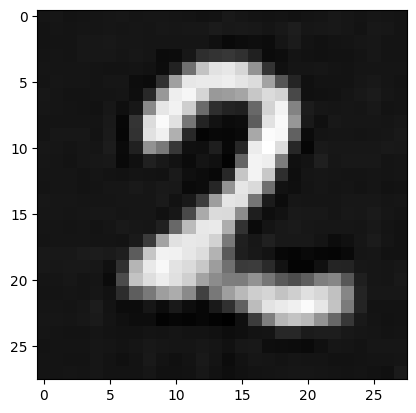

Label :  2


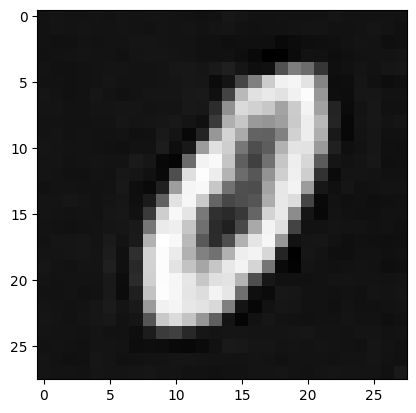

Label :  0


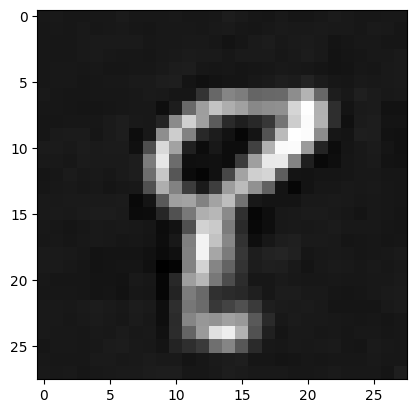

Label :  8


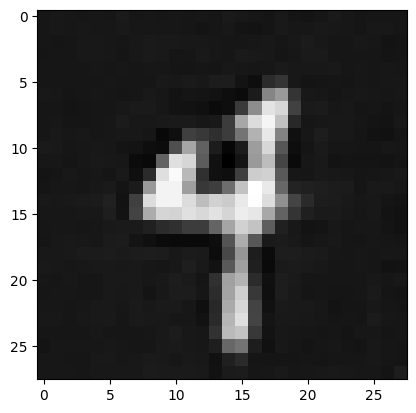

Label :  4


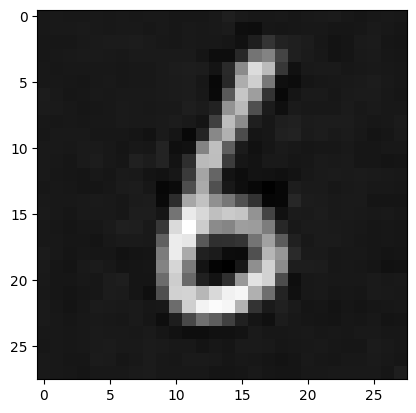

Label :  6


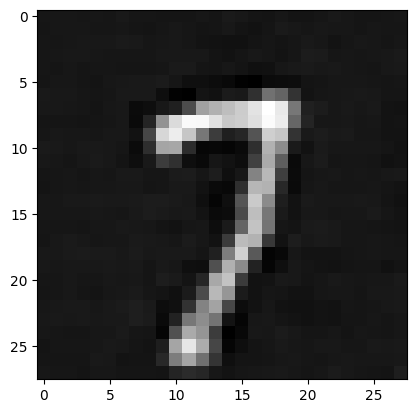

Label :  7


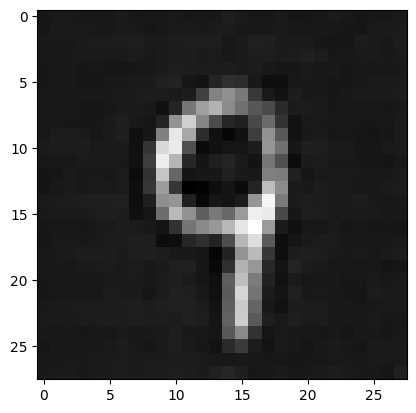

Label :  9


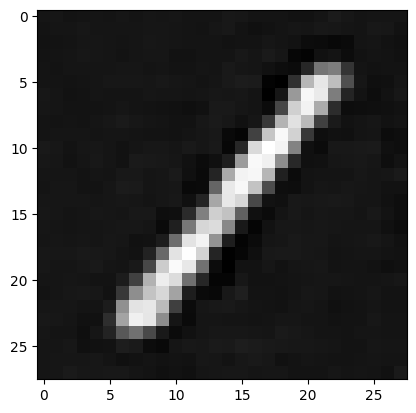

Label :  1


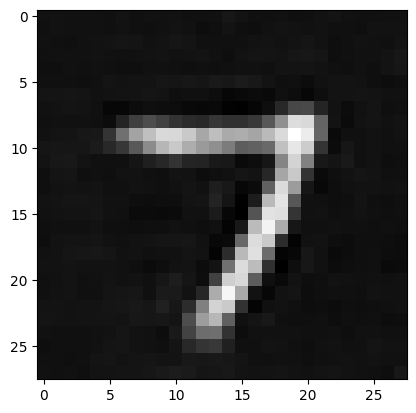

Label :  7


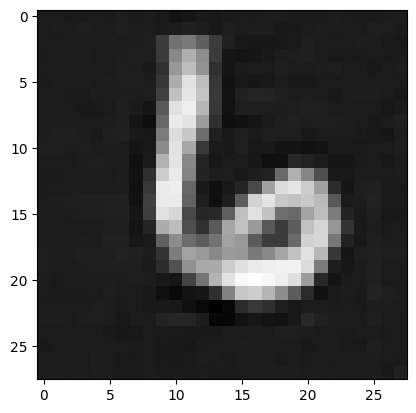

Label :  6


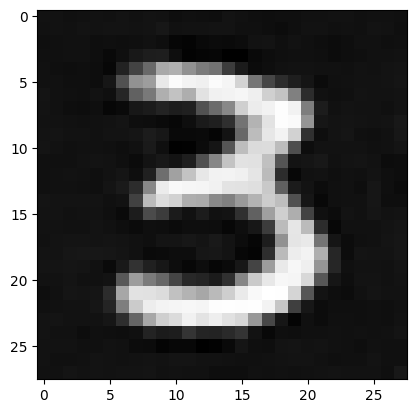

Label :  3


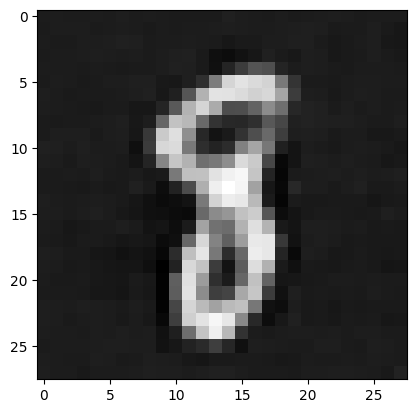

Label :  8


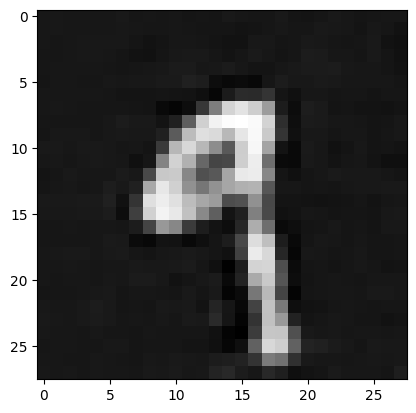

Label :  9


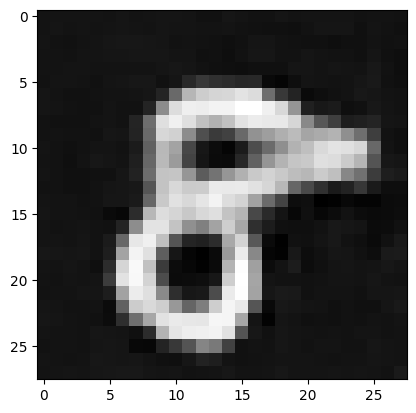

Label :  8


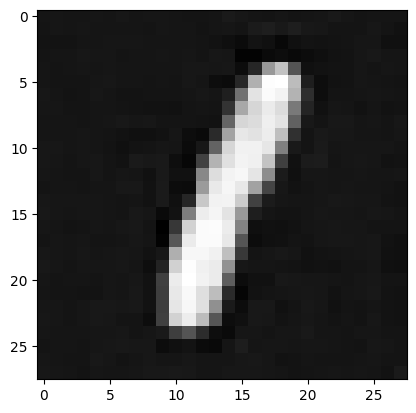

Label :  1


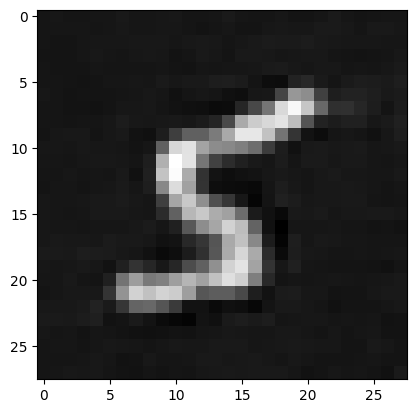

Label :  5


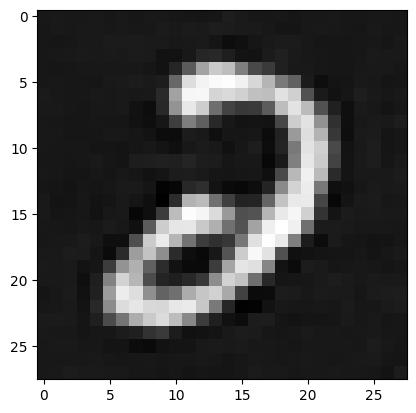

Label :  2


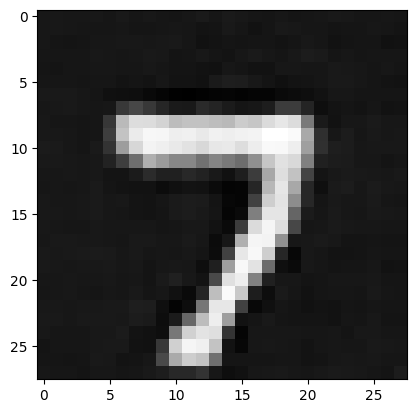

Label :  7


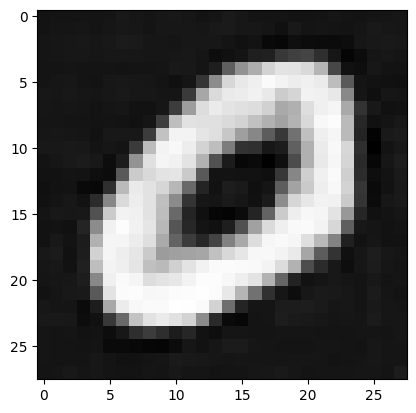

Label :  0


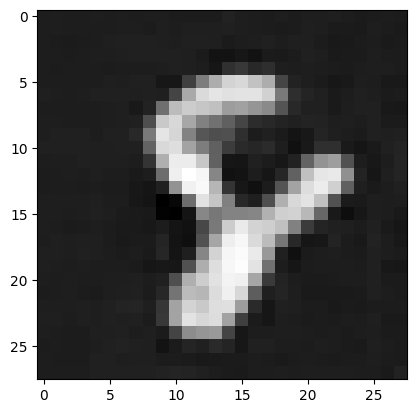

Label :  8


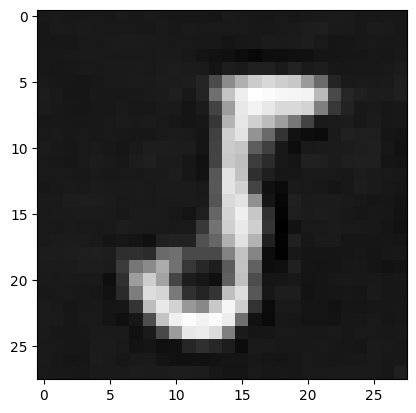

Label :  5


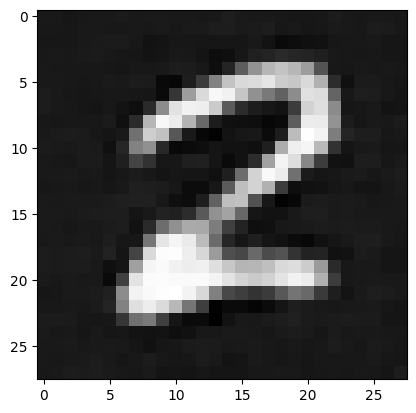

Label :  2


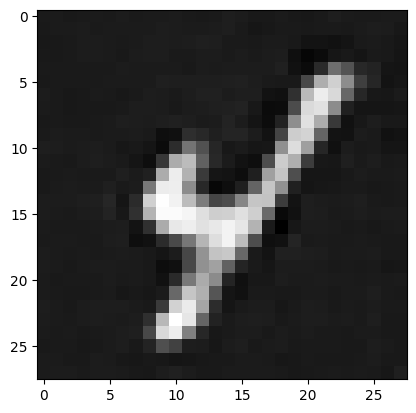

Label :  4


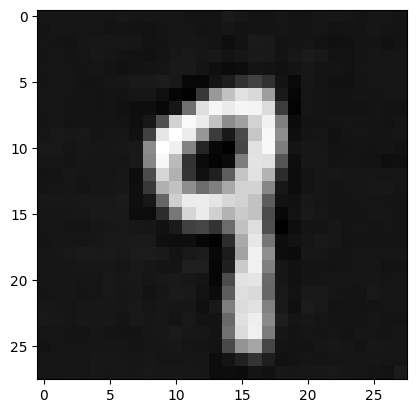

Label :  9


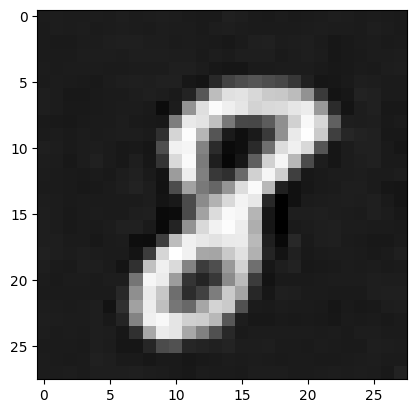

Label :  8


In [118]:
# visualize atleast five denoised images

for i in range(5):
  for j in range(5):
    plt.imshow(denoised_data[5*i+j].squeeze().cpu().numpy(), cmap="gray")
    plt.show()
    print("Label : ", labels[5*i+j].item())

In [119]:
epochs = 20
learning_rate = 0.001
use_dropout = True
dropout_rate = 0.2

NO_OF_CLASSES = 10
model = CNNModel(NO_OF_CLASSES,use_dropout= use_dropout,dropout= dropout_rate).cuda()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Train the model
    model.train()
    for images, labels in denoised_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(denoised_loader)
    train_acc /= len(denoised_trainset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        for images, labels in valloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()
        val_loss /= len(valloader)
        val_acc /= len(valset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1, Train Loss: 0.2598, Train Acc: 0.9198, Val Loss: 0.1471, Val Acc: 0.9554
Epoch 2, Train Loss: 0.1276, Train Acc: 0.9587, Val Loss: 0.1439, Val Acc: 0.9557
Epoch 3, Train Loss: 0.1054, Train Acc: 0.9665, Val Loss: 0.1433, Val Acc: 0.9553
Epoch 4, Train Loss: 0.0947, Train Acc: 0.9685, Val Loss: 0.1595, Val Acc: 0.9520
Epoch 5, Train Loss: 0.0852, Train Acc: 0.9721, Val Loss: 0.1620, Val Acc: 0.9517
Epoch 6, Train Loss: 0.0793, Train Acc: 0.9740, Val Loss: 0.1969, Val Acc: 0.9400
Epoch 7, Train Loss: 0.0726, Train Acc: 0.9756, Val Loss: 0.2252, Val Acc: 0.9282
Epoch 8, Train Loss: 0.0673, Train Acc: 0.9775, Val Loss: 0.1858, Val Acc: 0.9429
Epoch 9, Train Loss: 0.0638, Train Acc: 0.9789, Val Loss: 0.2181, Val Acc: 0.9321
Epoch 10, Train Loss: 0.0608, Train Acc: 0.9795, Val Loss: 0.2527, Val Acc: 0.9172
Epoch 11, Train Loss: 0.0574, Train Acc: 0.9806, Val Loss: 0.2501, Val Acc: 0.9218
Epoch 12, Train Loss: 0.0534, Train Acc: 0.9821, Val Loss: 0.2778, Val Acc: 0.9070
Epoch 13, Tra

In [123]:
model.eval()
with torch.inference_mode(True):
    y_true = []
    y_pred = []
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'F1 Score: {f1_score(y_true, y_pred, average="macro")}')
    print(f'Precision: {precision_score(y_true, y_pred, average="macro")}')
    print(f'Recall: {recall_score(y_true, y_pred, average="macro")}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_true, y_pred)}')
    print(f'Class Specific Metrics: \n{classification_report(y_true, y_pred)}')


Accuracy: 0.9021
F1 Score: 0.9016570849591728
Precision: 0.9026499382914894
Recall: 0.9021180297661516
Confusion Matrix: 
[[ 941    1    8    0    3    9    7    5    2    4]
 [   1 1065   10    0   17    3    3   21   14    1]
 [   5    5  918   15   14    0    7   14   52    2]
 [   2    1   33  872    0   41    5    5   41   10]
 [   0    2    4    1  928    1   12    6    6   22]
 [   2    0    3   15    2  798   20    0   43    9]
 [  12    0    0    1   13   27  893    0    8    4]
 [   0   15   31   10   13    3    0  892    7   57]
 [   4    5   22    7    5   12   14    6  886   13]
 [   1    8    5    8   84   16    2   38   19  828]]
Class Specific Metrics: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       980
           1       0.97      0.94      0.95      1135
           2       0.89      0.89      0.89      1032
           3       0.94      0.86      0.90      1010
           4       0.86      0.95      0.90       9